In [14]:
import pandas as pd
import json
import seaborn as sns
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
sns.set_style('whitegrid')
%matplotlib inline

In [15]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [16]:
def sort_experiment_paths(experiment_paths):
    data = []
    for path in experiment_paths:
        config = json.loads(open(f"{path}/experiment_config.json").read())
        data.append(dict(name=config["optimizer"]["name"], **config["optimizer"]["parameters"], path=path))
    return pd.DataFrame(data).sort_values(["name", "lr", "weight_decay"], ascending=["True", "False", "False"])['path']

In [17]:
experiment_paths = glob("../../study_results/densenet121_ADAM/*")
sorted_experiment_paths = sort_experiment_paths(experiment_paths)

In [18]:
def get_results(experiment_paths):
    configs = []
    results = []
    losses = []
    for path in experiment_paths:
        config = json.loads(open(f"{path}/experiment_config.json").read())
        result = pd.read_csv(f"{path}/all_results.csv")
        loss = pd.read_csv(f"{path}/loss_results.csv")
        configs.append(config)
        results.append(result)
        losses.append(loss)
    return zip(configs, results, losses)
    

In [19]:
def plot_results(ax, config, result):
    model = config["model"]["model_configuration_name"]
    optimizer = config["optimizer"]["name"]
    lr = config["optimizer"]["parameters"]["lr"]
    weight_decay = config["optimizer"]["parameters"].get("weight_decay")
    title = f"{model}\nLearning rate: {lr}\nOptimizer: {optimizer}\nWeight decay: {weight_decay or 'N/A'}"
    scheduler = config["scheduler"]
    grouped_losses = result.groupby(['train_or_validation','fold','epoch']).mean()
    avg_epoch_loss = result.groupby(['train_or_validation', 'epoch']).mean()

    sizes = dict()
    for name, level in zip(grouped_losses.index.names, grouped_losses.index.levels):
        sizes[name] = len(level)
    n_folds = sizes['fold']

    avg_train_epoch = avg_epoch_loss.loc['TRAIN']
    avg_val_epoch = avg_epoch_loss.loc['VALIDATION']
    sns.tsplot(avg_train_epoch['loss'], color='skyblue', linewidth=1.5, ax=ax)
    sns.tsplot(avg_val_epoch['loss'], color='red', linewidth=1.5, ax=ax)
    for i in range(n_folds):
        train = grouped_losses.loc['TRAIN'].loc[i]
        val = grouped_losses.loc['VALIDATION'].loc[i]
        sns.tsplot(train['loss'], color='skyblue', linewidth=1, alpha=0.3, ax=ax)
        sns.tsplot(val['loss'], color='red', linewidth=1, alpha=0.3, ax=ax)
        ax.set(ylim=(0, 0.8))
        ax.set_title(title)
        train_patch = mpatches.Patch(color='skyblue', label='TRAINING')
        val_patch = mpatches.Patch(color='red', label='VALIDATION')
        ax.legend(handles=[train_patch, val_patch])
        ax.set(xlabel="Epoch")
        ax.set(ylabel="Loss")

/home/kevin/miniconda3/envs/pytorch_0.3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


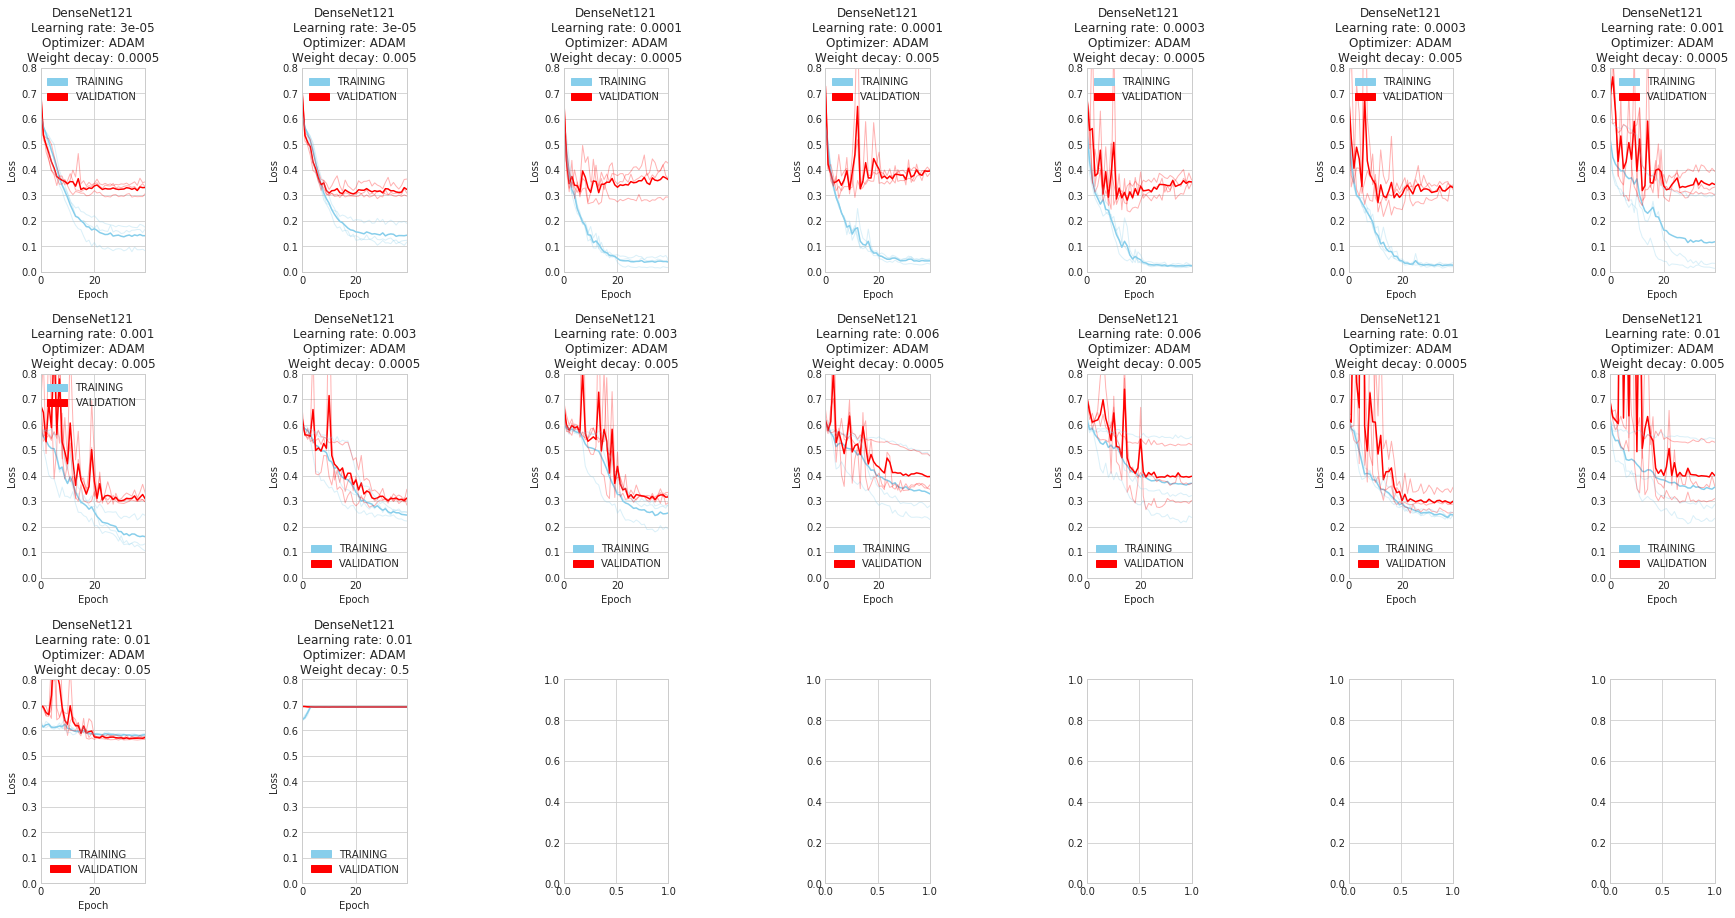

In [22]:
n_rows, n_cols = 3, 7
results = get_results(sorted_experiment_paths)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(30, 15))
fig.subplots_adjust(hspace=0.5, wspace=1.5)
for i, (config, result, _) in enumerate(results):  
    row = i // n_cols
    col = i % n_cols
    plot_results(axs[row][col], config, result)
    
# for row in range(n_rows):
#     for col in range(n_cols):
#         plot_results(axs[row][col], row * col + col)
# for i, (config, result) in enumerate(get_results(sorted_experiment_paths)):
#     plot_results(axs[i], config, result)